In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/shwetank/code/wiki-base')
import torch
# from datasets import load_dataset
# import tiktoken

# Setup device
device = torch.device("cuda")
device

device(type='cuda')

In [2]:
# Hyperparams
batch_size = 32
block_size = 256
emb_dim = 768
num_heads = 12
num_layers = 12
dropout = 0.2
linear_scaleup = 4
temperature = 1

# Optimization loop parameters
n_epochs = 100
eval_interval =10

In [3]:
with open('./data/shakespeare/input.txt', 'r', encoding='utf-8') as file:
    text_data = file.read()

n1 = int(0.9*len(text_data))
train_data = text_data[:n1]
val_data = text_data[n1:]
vocab = sorted(set(list(text_data)))
n_vocab = len(vocab)
print(f"vocab: {vocab}")
print(f"vocab length: {n_vocab}")

vocab: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
vocab length: 65


In [4]:
from torch.utils.data import Dataset
import torch

class CharacterDataset(Dataset):
    def __init__(self, dataset: Dataset, block_size: int=128, batch_size: int=16):
        self.block_size = block_size
        self.dataset = dataset
        self.batch_size = batch_size
        

    def __len__(self) -> int:
        return self.block_size

    def __getitem__(self, idx: int) -> tuple[torch.tensor, torch.tensor]:
        # x = torch.zeros((self.block_size + 1), dtype=torch.long)
        # y = torch.zeros((self.block_size + 1), dtype=torch.long)
        # print(idx)
        x = self.dataset[idx:idx+self.block_size]
        y = self.dataset[idx+1:idx+self.block_size+1]
        return x.to(device), y.to(device)

In [5]:
stoi = {s: i for i,s in enumerate(vocab)}
itos = {i:s for s,i in stoi.items()}
# print(stoi)
# print(itos)
def encode(text):
    tokens = torch.tensor([stoi[t] for t in text])
    return tokens

def decode(tokens):
    text = ''.join(itos[t] for t in tokens)
    return text

# tokens = encode('Hello world!')
# print(decode(tokens))

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Feedforward(nn.Module):
    def __init__(self,emb_dim,dropout) -> None:
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(emb_dim, linear_scaleup * emb_dim),
            nn.ReLU(),
            nn.Linear(linear_scaleup * emb_dim, emb_dim),
            nn.Dropout(dropout)
        )

    def forward(self,x):
        return self.ff(x)
    

class Block(nn.Module):
    def __init__(self, emb_dim, num_heads, dropout) -> None:
        super().__init__()
        self.head_size = emb_dim // num_heads
        self.sa_head = nn.MultiheadAttention(emb_dim, num_heads, dropout)
        self.ff = Feedforward(emb_dim, dropout)
        self.ln1 = nn.LayerNorm(emb_dim)
        self.ln2 = nn.LayerNorm(emb_dim)

    def forward(self, x, targets=None):
        x = self.ln1(x)
        sa_out, _ = self.sa_head(x,x,x)
        x = x + sa_out
        x = x + self.ff(self.ln2(x))
        return x


class Xformer(nn.Module):
    def __init__(self, emb_dim, n_vocab, num_heads, num_layers, dropout): 
        super().__init__()
        self.tok_emb = nn.Embedding(n_vocab, emb_dim)
        self.pos_emb = nn.Embedding(n_vocab, emb_dim)
       
        blocks = []
        for _ in range(num_layers):
            blocks.append(Block(emb_dim, num_heads, dropout))
        
        self.blocks = nn.Sequential(*blocks, nn.LayerNorm(emb_dim))
        self.lm_head = nn.Linear(emb_dim, n_vocab)

    def forward(self, x, targets=None):
        x = self.tok_emb(x) + self.pos_emb(x)
        x = self.blocks(x)
        logits = self.lm_head(x)

        loss = None
        if targets is not None:
            # print(logits.view(-1, logits.size(-1)).shape, targets.view(-1).shape)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        return(logits,loss)

# from models import Xformer_Scratch as Xformer

In [7]:
## Get dataloader for train and  val datasets from training and test data
# from torch.utils.data import DataLoader
# train_data_obj = WikiData(train_tensor, block_size=block_size)
# val_data_obj = WikiData(val_tensor, block_size=block_size)
# train_dataloader = DataLoader(train_data_obj, batch_size=1)
# val_dataloader = DataLoader(val_data_obj, batch_size=1)
from torch.utils.data import DataLoader
train_dataloader = DataLoader(CharacterDataset(encode(train_data)),batch_size=batch_size)
val_dataloader = DataLoader(CharacterDataset(encode(val_data)), batch_size=batch_size)

In [8]:
# Single test run
from torch.optim import Adam
xb, yb = next(iter(train_dataloader))
# print(xb.shape, yb.shape)
model = Xformer(emb_dim, n_vocab, num_heads, num_layers, dropout).to(device)
# model = Xformer(emb_dim, n_vocab, num_heads, num_layers, block_size, dropout).to(device)

logits, loss = model(xb,yb)
print(loss)

tensor(4.2897, device='cuda:0', grad_fn=<NllLossBackward0>)


In [9]:
from utils import get_model_size
get_model_size(model)

85205825

In [10]:
xb, yb = next(iter(train_dataloader))
print(xb.shape, yb.shape)

torch.Size([32, 128]) torch.Size([32, 128])


In [11]:
# ## Optimal lr sweep
# from utils import get_lr_loss
# num_epochs = 100
# lr = 0
# optimizer = Adam(model.parameters(), lr=lr)
# lri, lossi =  get_lr_loss(model, optimizer, train_dataloader, num_epochs, device, -5, -3)
# import matplotlib.pyplot as plt
# plt.plot(lri, lossi)
# # Add labels to the x-axis and y-axis
# plt.xlabel('LR (Learning Rate)')
# plt.ylabel('Loss')

In [12]:
tr_loss = []
vl_loss = []

In [13]:
from utils import evaluate_loss
lr = 1e-5
optimizer = Adam(model.parameters(), lr=lr)
for steps in range(1000):
    xb, yb = next(iter(train_dataloader))
    xb = xb.to(device)
    yb = yb.to(device)
    logits, loss = model(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    tr_lossi, te_lossi = evaluate_loss(model, train_dataloader, val_dataloader, device, num_batches=10)
    tr_loss.append(tr_lossi)
    vl_loss.append(te_lossi)
    # print(loss.item())
    print('ltr: ', tr_lossi, 'lte: ', te_lossi, 'single shot loss:', loss.item())

    # if steps % eval_interval-1 == 0:
    #     print('ltr: ', tr_lossi, 'lte: ', te_lossi, 'single shot loss:', loss.item())

ltr:  3.7744593620300293 lte:  4.0250163078308105 single shot loss: 4.285275459289551
ltr:  3.4372401237487793 lte:  3.908421039581299 single shot loss: 3.8114209175109863
ltr:  3.2368578910827637 lte:  3.8780016899108887 single shot loss: 3.4738311767578125
ltr:  3.0921616554260254 lte:  3.867283344268799 single shot loss: 3.270838737487793
ltr:  2.967170000076294 lte:  3.8499016761779785 single shot loss: 3.132232904434204
ltr:  2.856872797012329 lte:  3.828650951385498 single shot loss: 3.007201671600342
ltr:  2.757021427154541 lte:  3.807295560836792 single shot loss: 2.9081368446350098
ltr:  2.6620066165924072 lte:  3.7867608070373535 single shot loss: 2.80718731880188
ltr:  2.5691144466400146 lte:  3.7681374549865723 single shot loss: 2.7183005809783936
ltr:  2.4771695137023926 lte:  3.7518718242645264 single shot loss: 2.6298255920410156
ltr:  2.3851969242095947 lte:  3.7376627922058105 single shot loss: 2.5408148765563965
ltr:  2.2925050258636475 lte:  3.724693775177002 single 

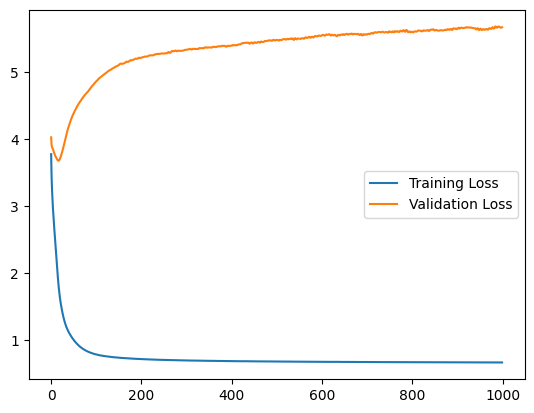

training loss:  0.6709
validation loss:  5.667


In [14]:
## Plot loss 
import matplotlib.pyplot as plt

plt.figure()
plt.plot(tr_loss, label='Training Loss')
# plt.figure()
plt.plot(vl_loss, label='Validation Loss')
plt.legend()
plt.show()
print('training loss: ', round(torch.mean(torch.tensor(tr_loss[-10:])).item(),4)), 
print('validation loss: ', round((torch.mean(torch.tensor(vl_loss[-10:]))).item(),4))

In [15]:
@torch.no_grad()
def generate(model, max_new_tokens=block_size, batch_size=batch_size, temperature=temperature):
    idx = torch.zeros((batch_size, 1), dtype=torch.long).to(device)
    for _ in range(max_new_tokens):
        # print('idx shape:',idx.shape)
        idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
        idx_cond = idx_cond.to(device)
        logits, _ = model(idx_cond)
        # Pick only the logits from most recent time step. Karpathy also does a divide by temp?
        # This is just Platt scaling which makes the various Softmax curves closes adding more randomness
        # see scratch.ipynb. https://en.wikipedia.org/wiki/Platt_scaling
        logits = logits[:,-1,:]/temperature
        probs = F.softmax(logits, dim=-1)
        # print('prob dist:',probs)
        idx_next = torch.multinomial(probs, num_samples=1)
        # print('idx_next shape:',idx_next.shape)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx


In [16]:
X_samp = generate(model, block_size*2, 1, temperature).tolist()

In [17]:
for row in X_samp:
    print(decode(row))


sssT&rtCCCCCynnnKL,.ennnnnn&tCiiisCCcpektwwe'
?h fhrrrrrrttnnnnnnnvuFF RdkPe.iO'uuuupp$enn:mmRvYzBeennXi?
QppX::znnPpvTll:ZnnnnnnnnZny,,,,OK hcRed?
-KnnnnyVnnnnnnnFFga.
RKhediisarrrrrrrrt,,rlllllllllceextYJ-
YYg
xgoNDuuJtd  fZ diCCpe eeeesQfJCtgHisolvYYtti$dB
;is?
UPDged h pHizBeny,Spppmq muuuuuged 3ll INHiis
ve mmOGffpeennoa$nnnnnnnffffvtt nnnEyedii&l:pppppss,,,,pefww:
ez m,?
RssfE:isvu  ditaCCCCKk,,,,,,,Znnynnnnn:MtoOZnyF ak,,d d

.
Rovtt disF  ppp?
R;3,,eewBeek,,,$eerrAtiraaaZ diisalRoE&tX::tCCizntpe mmm
